# Classifying Tweet about Covid-19


## Imports

In [10]:
from argparse import Namespace
from collections import Counter
import json
import os
import re
import string

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
import nltk

## Data Vectorization classes

### The Vocabulary

In [11]:
class Vocabulary(object):
    """Class to process text and extract vocabulary for mapping"""

    def __init__(self, token_to_idx=None, add_unk=True, unk_token="<UNK>"):

        if token_to_idx is None:
            token_to_idx = {}
        self._token_to_idx = token_to_idx         # _token_to_idx: {'<UNK>':0, 'apple':1, 'banana':2, ....., 'zzz':10000}
                                                  # _idx_to_token: {0:'<UNK>', 1:'apple', 2:'banana', ....., 10000:'zzz'}

        self._idx_to_token = {idx: token          
                              for token, idx in self._token_to_idx.items()} 
        
        self._add_unk = add_unk
        self._unk_token = unk_token
        
        self.unk_index = -1
        if add_unk:
            self.unk_index = self.add_token(unk_token)        

    def add_token(self, token):
        if token in self._token_to_idx:
            index = self._token_to_idx[token]
        else:
            index = len(self._token_to_idx)
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token
        return index
    
    def lookup_token(self, token):
        if self.unk_index >= 0:                   # if unk_token is defined, unknown words are handled
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]

    def lookup_index(self, index):
        if index not in self._idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self._idx_to_token[index]

    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)

    def __len__(self):
        return len(self._token_to_idx)

### The Vectorizer

In [12]:
class TweetVectorizer(object):
    """ The Vectorizer which coordinates the Vocabularies and puts them to use"""
    def __init__(self, tweet_vocab, rating_vocab):
        self.tweet_vocab = tweet_vocab     
        self.rating_vocab = rating_vocab   

    def vectorize(self, tweet):
        one_hot = np.zeros(len(self.tweet_vocab), dtype=np.float32)
        words = tweet.split(" ")
        for token in words:
            if token not in string.punctuation:
                one_hot[self.tweet_vocab.lookup_token(token)] += 1 

        return one_hot  
    
    @classmethod
    def from_dataframe(cls, tweet_df, cutoff=25):
        tweet_vocab = Vocabulary(add_unk=True)   # create an instance of Vocabulary class
        rating_vocab = Vocabulary(add_unk=False)
        
        # Add ratings
        for rating in sorted(set(tweet_df.rating)):  
            rating_vocab.add_token(rating)          

        # Add top words if count > provided count
        word_counts = Counter()
        for tweet in tweet_df.tweet:
            words = tweet.split(" ")
            for word in words:
                if word not in string.punctuation:
                    word_counts[word] += 1
               
        for word, count in word_counts.items():
            if count > cutoff:
                tweet_vocab.add_token(word)         

        return cls(tweet_vocab, rating_vocab)

### The Dataset

In [13]:
class TweetDataset(Dataset):
    def __init__(self, tweet_df, vectorizer):
        self.tweet_df = tweet_df
        self._vectorizer = vectorizer

        self.train_df = self.tweet_df[self.tweet_df.split=='train']
        self.train_size = len(self.train_df)

        self.val_df = self.tweet_df[self.tweet_df.split=='val']
        self.validation_size = len(self.val_df)

        self.test_df = self.tweet_df[self.tweet_df.split=='test']
        self.test_size = len(self.test_df)

        self._lookup_dict = {'train': (self.train_df, self.train_size),
                             'val': (self.val_df, self.validation_size),
                             'test': (self.test_df, self.test_size)}

        self.set_split('train')

    @classmethod
    def load_dataset_and_make_vectorizer(cls, tweet_csv, frequency_cutoff):
        tweet_df = pd.read_csv(tweet_csv, encoding='latin2')
        tweet_df.columns =  ['tweet','rating','split']
        
        EngWords = set(nltk.corpus.words.words())
        StopWords = set(nltk.corpus.stopwords.words("english"))
        wnl = nltk.WordNetLemmatizer()

        for i in range(len(tweet_df)):
            tweet_str = tweet_df.loc[i, 'tweet']
            words = nltk.word_tokenize(tweet_str)
            #words = [wnl.lemmatize(word.lower()) for word in words 
            #         if word in EngWords and word.lower() not in StopWords]
            words = [wnl.lemmatize(word.lower()) for word in words]
            
            tweet_str = " ".join(words)
            tweet_df.loc[i, 'tweet'] = tweet_str
            
        train_tweet_df = tweet_df[tweet_df.split=='train']
        return cls(tweet_df, TweetVectorizer.from_dataframe(train_tweet_df, frequency_cutoff))
    
    def get_vectorizer(self):
        """ returns the vectorizer """
        return self._vectorizer

    def set_split(self, split="train"):
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]

    def __len__(self):
        return self._target_size

    def __getitem__(self, index):
        row = self._target_df.iloc[index]

        tweet_vector = \
            self._vectorizer.vectorize(row.tweet)

        rating_index = \
            self._vectorizer.rating_vocab.lookup_token(row.rating)

        return {'x_data': tweet_vector,           #  e.g., { 'x_data': [0, 0, 1, 0, 1, ....., 0, 0],
                'y_target': rating_index}          #          'y_target': 0  }

    def get_num_batches(self, batch_size):
        return len(self) // batch_size  # the floor division // rounds the result down to the nearest whole number
    
    #shuffle=True
def generate_batches(dataset, batch_size, shuffle=False,
                     drop_last=True, device="cpu"):
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last)

    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():  # name: x_data & y_target
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict

## The Model: TweetClassifier

In [14]:
class TweetClassifier(nn.Module):
    def __init__(self, num_features, hidden_dim):
        super(TweetClassifier, self).__init__()
        self.fc1 = nn.Linear(in_features=num_features, out_features=hidden_dim) 
        self.fcm = nn.Linear(in_features=hidden_dim, out_features=hidden_dim)  
        self.fc2 = nn.Linear(in_features=hidden_dim, out_features=2)           

    def forward(self, x_in):
        intermediate = self.fc1(x_in)           
        intermediate = F.relu(intermediate)      
        intermediate1 = self.fcm(intermediate)  
        intermediate1 = F.relu(intermediate1)    
        y_out = self.fc2(intermediate1)         
        return y_out

## Training Routine

### Helper functions

In [15]:
def make_train_state():
    return {'stop_early': False,
            'early_stopping_step': 0,
            'early_stopping_best_val': 1e8,
            'learning_rate': args.learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'test_loss': -1,
            'test_acc': -1,
            'model_filename': args.model_state_file}

def compute_accuracy(y_pred, y_target):
    y_target = y_target.cpu()
    y_pred_indices = y_pred.max(dim=1).indices.cpu().long() 
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()  # item() to get a Python number from a tensor containing a single value
    return n_correct / len(y_pred_indices) * 100

def update_train_state(args, model, train_state):
    # Save one model at least
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        train_state['stop_early'] = False

    # Save model if performance improved
    elif train_state['epoch_index'] >= 1:
        loss_tm1, loss_t = train_state['val_loss'][-2:]

        # If loss worsened
        if loss_t >= train_state['early_stopping_best_val']:
            # Update step
            train_state['early_stopping_step'] += 1
        # Loss decreased
        else:
            # Save the best model
            if loss_t < train_state['early_stopping_best_val']:
                torch.save(model.state_dict(), train_state['model_filename'])
                train_state['early_stopping_best_val'] = loss_t  # update 'early_stopping_best_val'

            # Reset early stopping step
            train_state['early_stopping_step'] = 0

        # Stop early ?
        train_state['stop_early'] = \
            train_state['early_stopping_step'] >= args.early_stopping_criteria

    return train_state

#### General utilities

In [16]:
def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)

### Settings and some prep work

In [17]:
args = Namespace(
    # Data and Path information
    model_state_file='model.pth',
    frequency_cutoff=0, 
    tweet_csv='data/Corona_NLP_final.csv',
    # Model hyper parameters
    hidden_dim=30,
    # Training hyper parameters
    batch_size=64,
    learning_rate=0.002,
    num_epochs=15,
    seed=1337,
    # Runtime options
    catch_keyboard_interrupt=True,
    cuda=True,
    early_stopping_criteria=5, 
)
  
# Check CUDA
if not torch.cuda.is_available():
    args.cuda = False

print("Using CUDA: {}".format(args.cuda))

args.device = torch.device("cuda" if args.cuda else "cpu")

# Set seed for reproducibility
set_seed_everywhere(args.seed, args.cuda)

Using CUDA: False


### Initializations

In [18]:
print("Loading dataset and creating vectorizer")
# create dataset and vectorizer
dataset = TweetDataset.load_dataset_and_make_vectorizer(args.tweet_csv, args.frequency_cutoff) 

vectorizer = dataset.get_vectorizer()

classifier = TweetClassifier(num_features=len(vectorizer.tweet_vocab), hidden_dim=args.hidden_dim)

Loading dataset and creating vectorizer


In [19]:
str(vectorizer.tweet_vocab), str(vectorizer.rating_vocab)

('<Vocabulary(size=54691)>', '<Vocabulary(size=2)>')

### Training loop

In [50]:
classifier = classifier.to(args.device)

loss_func = nn.CrossEntropyLoss() 
optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate)

train_state = make_train_state()

epoch_bar = tqdm(desc='training routine', total=args.num_epochs)  # progress bar

dataset.set_split('train')
train_bar = tqdm(desc='split=train', total=dataset.get_num_batches(args.batch_size), leave=True)

dataset.set_split('val')
val_bar = tqdm(desc='split=val', total=dataset.get_num_batches(args.batch_size), leave=True)

try:
    for epoch_index in range(args.num_epochs):
 
        # Iterate over training dataset

        # setup: batch generator, set loss and acc to 0, set train mode on
        dataset.set_split('train')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.0
        running_acc = 0.0
        classifier.train()

        for batch_index, batch_dict in enumerate(batch_generator):
            # the training routine is these 5 steps:

            # --------------------------------------
            # step 1. zero the gradients
            optimizer.zero_grad()

            # step 2. compute the output
            y_pred = classifier(x_in=batch_dict['x_data'].float()) # [batch, num_features] -> [batch]

            # step 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_target']) #！
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            # step 4. use loss to produce gradients
            loss.backward()

            # step 5. use optimizer to take gradient step
            optimizer.step()
            # -----------------------------------------
            # compute the accuracy
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)
            
            # update bar
            train_bar.set_postfix(loss=running_loss, 
                                  acc=running_acc, 
                                  epoch=epoch_index)
            train_bar.update()
        
        train_state['train_loss'].append(running_loss) # train_loss for each epoch
        train_state['train_acc'].append(running_acc)   # train_acc for each epoch

        # Iterate over val dataset

        # setup: batch generator, set loss and acc to 0; set eval mode on
        dataset.set_split('val')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.
        running_acc = 0.
        classifier.eval()

        for batch_index, batch_dict in enumerate(batch_generator):

            # compute the output
            y_pred = classifier(x_in=batch_dict['x_data'].float())

            # step 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_target']) #！
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            # compute the accuracy
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)
            
            val_bar.set_postfix(loss=running_loss, 
                                acc=running_acc, 
                                epoch=epoch_index)
            val_bar.update()

        train_state['val_loss'].append(running_loss)   # val_loss for each epoch
        train_state['val_acc'].append(running_acc)     # val_acc for each epoch
        
        train_state = update_train_state(args=args, model=classifier,
                                         train_state=train_state)

        train_bar.n = 1  # reset number of finished iterations
        val_bar.n = 1
        epoch_bar.update()
        
except KeyboardInterrupt:
    print("Exiting loop")

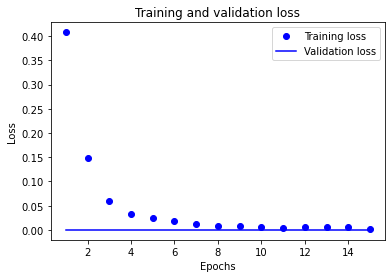

In [51]:
%matplotlib inline
import matplotlib.pyplot as plt

acc = train_state['train_acc']
val_acc = train_state['val_acc']
loss = train_state['train_loss']
val_loss = train_state['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

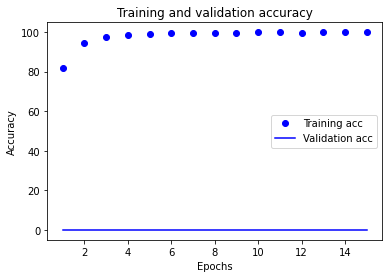

In [52]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [53]:
dataset.set_split('test')
batch_generator = generate_batches(dataset, 
                                   batch_size=args.batch_size, 
                                   device=args.device)
running_loss = 0.
running_acc = 0.
classifier.eval()

y_pred_list = []    # store predicted values for confusion matrix
y_target_list = []  # ground truth value

for batch_index, batch_dict in enumerate(batch_generator):
    # compute the output
    y_pred = classifier(x_in=batch_dict['x_data'].float())
    
    # store predicted values and ground truth values for calculating confusion matrix
    # y_pred_list.extend((y_pred>0.5).cpu().long().numpy())
    y_pred_list.extend(y_pred.max(dim=1).indices.cpu().long().numpy())
    y_target_list.extend(batch_dict['y_target'].cpu().numpy())
    
    # compute the loss
    loss = loss_func(y_pred, batch_dict['y_target']) #！
    loss_t = loss.item()
    running_loss += (loss_t - running_loss) / (batch_index + 1)

    # compute the accuracy
    acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
    running_acc += (acc_t - running_acc) / (batch_index + 1)

train_state['test_loss'] = running_loss
train_state['test_acc'] = running_acc

In [54]:
print("Test loss: {:.3f}".format(train_state['test_loss']))
print("Test Accuracy: {:.2f}".format(train_state['test_acc']))

Test loss: 1.105
Test Accuracy: 83.35


In [31]:
rating_classes = []
for i in range(len(dataset._vectorizer.rating_vocab)):
    rating_classes.append(dataset._vectorizer.rating_vocab.lookup_index(i))
print(rating_classes)

['Negative', 'Positive']


In [55]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pandas as pd
cm = confusion_matrix(y_target_list, y_pred_list)
cm_df = pd.DataFrame(cm.T, index=rating_classes, columns=rating_classes)
cm_df.index.name = 'Predicted'
cm_df.columns.name = 'True'
print(cm_df)

True       Negative  Positive
Predicted                    
Negative       1361       269
Positive        253      1253


In [56]:
print(classification_report(y_target_list, y_pred_list))

              precision    recall  f1-score   support

           0       0.83      0.84      0.84      1614
           1       0.83      0.82      0.83      1522

    accuracy                           0.83      3136
   macro avg       0.83      0.83      0.83      3136
weighted avg       0.83      0.83      0.83      3136



### Prediction

In [21]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"([.,!?])", r" \1 ", text)     # E.g., convert "end." to "end . "
    text = re.sub(r"[^a-zA-Z.,!?]+", r" ", text)  # replace special character strings with empty string
    return text

In [22]:
def predict_rating(tweet, classifier, vectorizer, decision_threshold=0.5):
    tweet = preprocess_text(tweet)
    
    vectorized_tweet = torch.tensor(vectorizer.vectorize(tweet))
    result = classifier(vectorized_tweet.view(1, -1))  # convert a vector to a matrix
    
    index = 1
    if result.max(dim=1).indices == False:
        index = 0

    return vectorizer.rating_vocab.lookup_index(index)


In [23]:
test_tweet = "The pandemic is quite awful"
classifier = classifier.cpu()
prediction = predict_rating(test_tweet, classifier, vectorizer, decision_threshold=0.5)
print("{} -> {}".format(test_tweet, prediction))

The pandemic is quite awful -> Negative


### End